# Sheet 05

* all the variouse modules and packages that might be required for this sheet

In [29]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place
import scipy
from scipy.stats import skew
from IPython.display import HTML # in line animations

import os   # file and file path

from itertools import count
import pandas as pd
import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

### Random walk

The random walk, is simple. So the easiest way to implement is by a simple for loop with short initiation process. 

In [30]:
N=20000  # number of iteration steps

number_of_particles=10000  # number of particles
n_bins=25
x = np.zeros((N+1,number_of_particles),dtype=int) # contains all positions for all time steps

# for loop to simulate a random walk
for i in range(N):
    
    dw= np.random.uniform(low=0.0,high=1.0,size=number_of_particles)  # here we draw from a uniform random distribution between 0 and 1 for all particles
    
    dw = np.where(dw<0.5, -1,1)  # here we condition the list of random variables and out put a list of 0 || 1
    
    x[i+1,:]= x[i]+dw  # then the position get iterated

In the next few snippets of code I plot the sulutions of the variouse stepps 

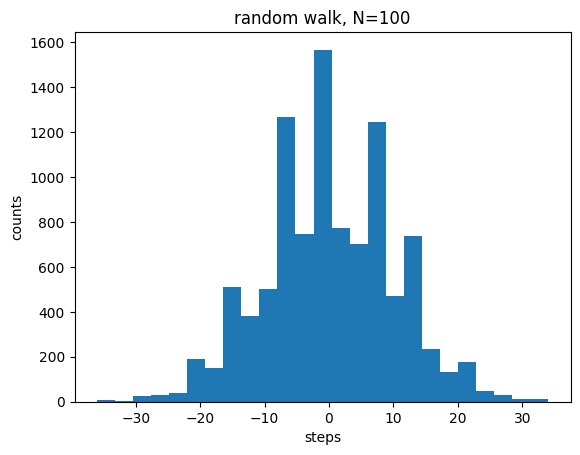

In [31]:
plt.title("random walk, N=100")
plt.hist(x[100],bins=n_bins)
plt.ylabel("counts")
plt.xlabel("steps")
plt.savefig("RW_N100.png")
plt.show()
plt.close()

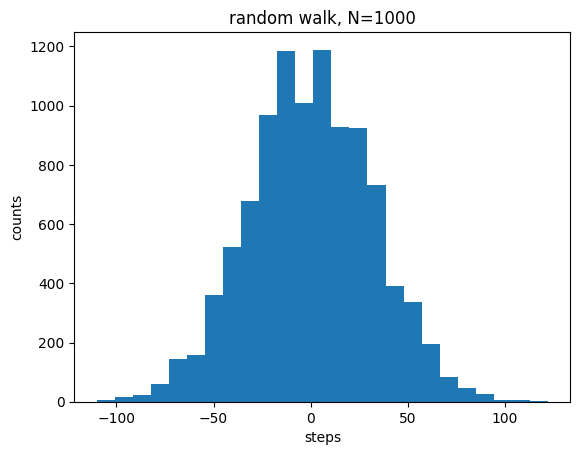

In [32]:
plt.title("random walk, N=1000")
plt.hist(x[1000],bins=n_bins)
plt.ylabel("counts")
plt.xlabel("steps")
plt.savefig("RW_N1000.png")
plt.show()
plt.close()

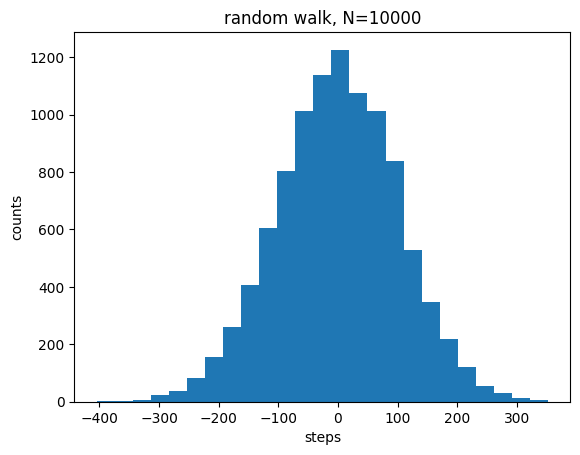

In [33]:
plt.title("random walk, N=10000")
plt.hist(x[10000],bins=n_bins)
plt.ylabel("counts")
plt.xlabel("steps")
plt.savefig("RW_N10000.png")
plt.show()
plt.close()

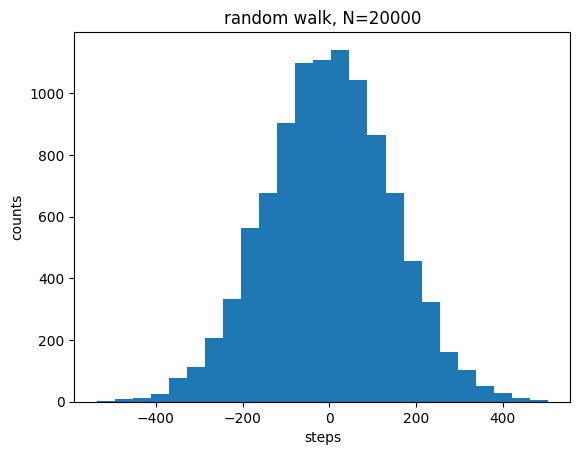

In [34]:
plt.title("random walk, N=20000")
plt.hist(x[20000],bins=n_bins)
plt.ylabel("counts")
plt.xlabel("steps")
plt.savefig("RW_N20000.png")
plt.show()
plt.close()

* next the variouse moments of the four distributios shall be determined

#### Expectation Values

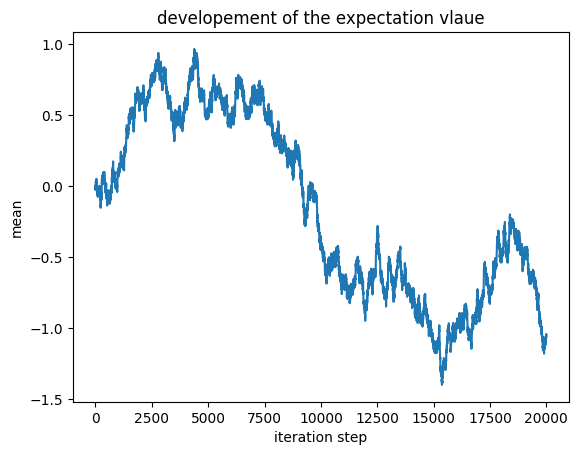

In [35]:
mu=np.mean(x,1)
plt.plot(np.arange(len(mu)),mu)
plt.title("developement of the expectation vlaue")
plt.ylabel("mean")
plt.xlabel("iteration step")
plt.savefig("expectationvalues.png")
plt.show()
plt.close()

#### Variance - Second moment

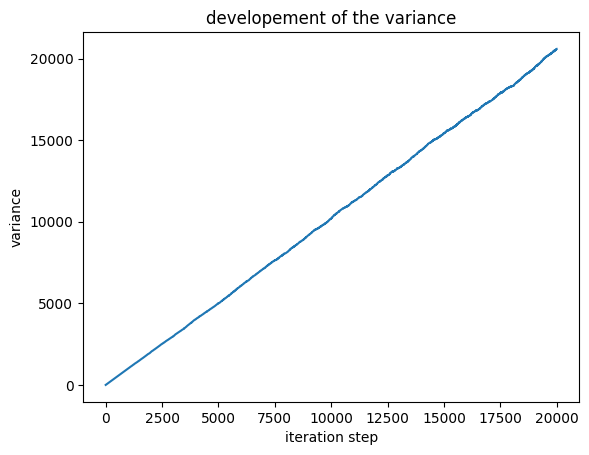

In [36]:
var=np.var(x,1)
plt.plot(np.arange(len(var)),var)
plt.title("developement of the variance")
plt.ylabel("variance")
plt.xlabel("iteration step")
plt.savefig("variancenvalues.png")
plt.show()
plt.close()

#### Skewness - Third moment
* the skew - funciton by scipy.stats made my laptop crash if I didnt cut the function into at least 2 halves. I made 4 to be sure that it works.
My guess is, that my RAM got overfilled, as I do have big lists ...

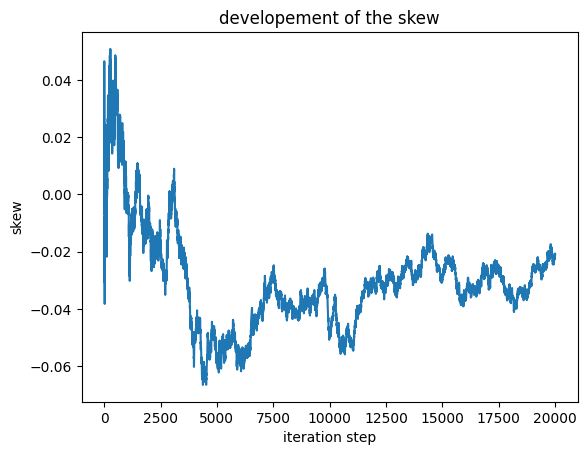

In [37]:
scew = np.zeros(N)

scew[0:5000]= skew(x[0:5000],axis=1,bias=True,nan_policy="raise")
scew[5000:10000]= skew(x[5000:10000],axis=1,bias=True,nan_policy="raise")
scew[10000:15000]= skew(x[10000:15000],axis=1,bias=True,nan_policy="raise")
scew[15000:20000]= skew(x[15000:20000],axis=1,bias=True,nan_policy="raise")

plt.plot(np.arange(len(scew)),scew)
plt.title("developement of the skew")
plt.ylabel("skew")
plt.xlabel("iteration step")
plt.savefig("scewness.png")
plt.show()
plt.close()

### particles in a reflective Box

* first off we need to simulate

In [38]:
class Particle:
    """
    Container for all particles of a simulation with the same attributes and interactions.

    Fields:

        n: (int)
                -> Number of particles 

        m: (float)
                -> Mass of the paricles

        d: (int)
                -> Dimension in which the particles live

        r: (float)
                -> Radius of particles

        x: (NDArray[np.flaot64]), (d, n)
                -> Array of positions vectors; All positions

        v:  (NDArray[np.flaot64]), (d, n)
                -> Array of velocity vectors; All velocities

        a:  (NDArray[np.flaot64]), (d, n)
                -> Array of acceleration vectors; All accelerations
    """
    def __init__(
        self,
        number: int,
        mass: float | int,
        radius: float | int,
        dimensions: int = 2
    ):
        """
        Initiate particles with unpecified positions, velocities, accelerations.
        """
        # constants
        self.n: int = number
        self.m: float = float(mass)
        self.d: int = dimensions
        self.r: float = radius

        self.x: NDArray[np.float64]= np.zeros((dimensions,number))
        self.v: NDArray[np.float64]= np.zeros((dimensions,number))
        self.a1: NDArray[np.float64]= np.zeros((dimensions,number))        

### initiating particles on a grid

In [39]:
def initiate_positions_on_grid(
        number_of_particles: int,
        box: tuple[float|int, float|int]
) -> None:
    """
    Initializes 2D positions on a Grid with even spacing.

    Parameters:
                
        n_particles:(int)
                -> number of particles

        box:(tuple[number,number]) 
                -> box size (in [nm])

    Return:

        (NDArray[float]) -> list of vectors of positons
    """
    grid_sections = int(np.ceil(np.sqrt(number_of_particles)))  # find the number of colums & rows

    # even spacing
    x_spacing = box[0]/grid_sections 
    y_spacing = box[1]/grid_sections
    # makes grid coordinates
    x, y= np.meshgrid(
        np.arange(grid_sections) * x_spacing, 
        np.arange(grid_sections) * y_spacing
    )
    x,y= x.flatten()[:number_of_particles], y.flatten()[:number_of_particles]
    return np.linalg.matrix_transpose(np.array([x,y]))   

In [40]:
def initiate_velocities_temperature(
        number_of_particles: int,
        temperature: float|int,
        mass: float|int,
        k_B: float= 1.380649*10**(-23),
        dimension: int= 2
)-> None:
    """
    Initiation of 2D velocity vectors to a Boltzmann distribution to a given temperature.

    Parameters:

        n_particles: (int)
                -> number of particles in the system

        temperature: (number)
                -> temperature of the system (in [K])

        mass: (number)
                -> mass of the particles  (in [kg])

    Return:

        velocities:(NDArray[float])
                -> velocities with Boltzmann distribution to a given temperature
    """
    # Initialize velocities for each particle in two dimensions
    std_dev = np.sqrt(k_B * temperature / mass)**dimension
    velocities = np.random.normal(0, std_dev, (number_of_particles, dimension))

    # Remove net momentum to ensure the center of mass is stationary
    mean_velocity = np.mean(velocities, axis=0)
    velocities -= mean_velocity

    return velocities 
    

* boundry conditions: reflecting

In [41]:
def reflecting_boundry_conditions(
        particle :Particle,
        box: tuple[float|int,float|int]
        ) -> None:
    """
    Reflecs particles on the boundries given by the box.

    Parameters:

        particle: (Particle)
                -> particles of the simulation

        box: (tuple[number, number])
                -> box in which the particles are kept 
    """
    for dim in range(particle.d):
            # Reflect particles crossing lower bound
            particle.x[dim, :] = np.where(
                    particle.x[dim, :] < box[0],
                    2 * box[0] - particle.x[dim, :],
                    particle.x[dim, :]
                )
            particle.v[dim, :] = np.where(
                    particle.x[dim, :] < box[0],
                    -particle.v[dim, :],
                    particle.v[dim, :]
                )

            # Reflect particles crossing the upper bound
            particle.x[dim, :] = np.where(
                    particle.x[dim, :] > box[1],
                    2 * box[1] - particle.x[dim, :],
                    particle.x[dim, :]
                )
            particle.v[dim, :] = np.where(
                    particle.x[dim, :] > box[1],
                    -particle.v[dim, :],
                    particle.v[dim, :]
                )
    pass



In [42]:
BOX = (10,10)  # [nm]
R=0.2   # radius of hard spheres in [nm]
MASS= 1
K_B= 1.380649*10**(-23)  # [J/K]

N: NDArray[np.int]= np.array([5,25,50]) # number of particles
M: NDArray[np.int]= np.array([5,25,50])

DT = 0.002  #  integration step size [ns]
VELOCITY= 0.5  # velocity [nm/ns]
T:float= MASS*VELOCITY**2/len(BOX)/K_B  #  temperature [K]

for j in M:
    ensemble: list[Particle]= [Particle(number=N[i],mass=MASS,radius=R,dimensions=len(BOX)) for i in range(j)]  # generate an array of independant simulations   
    print("Ensemble size:", len(p1))
    if len(ensemble) != M[j]:   #  help for finding errors
        print("Error, ensemble size is not correct!")
        break
    
    for p in ensemble:
        p.x= initiate_positions_on_grid(number_of_particles=p[i].n,box=(BOX[0]/2,BOX[1]))
        p.v= initiate_velocities_temperature(number_of_particles=p[i].n,temperature=T, mass=MASS)




AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations